# Capstone Presentation

I will be investigating a Kaggle dataset gathered from a [Speed Dating Experiment](https://www.kaggle.com/annavictoria/speed-dating-experiment). It was compiled by 2 Columbia Business School professors for their paper "Gender Differences in Mate Selection: Evidence From a Speed Dating Experiment", which they wrote in an effort to understand what influences "love at first sight".

Data was gathered from participants in experimental speed dating events 2002 - 2004. During the events, the attendees had a 4-minute "first date" with every other participant of the opposite sex. At the end of their 4 minutes, participants rated their date on 6 attributes: 

- Attractiveness
- Sincerity
- Intelligence
- Fun
- Ambition
- Shared Interests

The dataset also includes questionnaire data gathered from participants at different points in the process (i.e. demographics, dating habits, self-perception across key attributes, beliefs on what others find valuable in a mate, and lifestyle information). 

My goal is to be able to take this questionnaire data (namely each person's preferences, ratings, thoughts on the opposite sex's preferences, thoughts on how he/she measures up to opposite sex's preferences, etc.) to predict whether 2 people will be a match.

## Explore & Clean Data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import linear_model
from sklearn import ensemble
from sklearn.svm import SVC
from collections import Counter
from itertools import compress
from sklearn.naive_bayes import BernoulliNB
from sklearn.model_selection import train_test_split, cross_val_score
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import MinMaxScaler, normalize

raw_data = pd.read_csv('./data/speed_dating.csv', encoding="ISO-8859-1")
print(list(raw_data.columns))
print(raw_data.shape[0], 'Rows')
print(raw_data.shape[1], 'Columns')
raw_data.head()

['iid', 'id', 'gender', 'idg', 'condtn', 'wave', 'round', 'position', 'positin1', 'order', 'partner', 'pid', 'match', 'int_corr', 'samerace', 'age_o', 'race_o', 'pf_o_att', 'pf_o_sin', 'pf_o_int', 'pf_o_fun', 'pf_o_amb', 'pf_o_sha', 'dec_o', 'attr_o', 'sinc_o', 'intel_o', 'fun_o', 'amb_o', 'shar_o', 'like_o', 'prob_o', 'met_o', 'age', 'field', 'field_cd', 'undergra', 'mn_sat', 'tuition', 'race', 'imprace', 'imprelig', 'from', 'zipcode', 'income', 'goal', 'date', 'go_out', 'career', 'career_c', 'sports', 'tvsports', 'exercise', 'dining', 'museums', 'art', 'hiking', 'gaming', 'clubbing', 'reading', 'tv', 'theater', 'movies', 'concerts', 'music', 'shopping', 'yoga', 'exphappy', 'expnum', 'attr1_1', 'sinc1_1', 'intel1_1', 'fun1_1', 'amb1_1', 'shar1_1', 'attr4_1', 'sinc4_1', 'intel4_1', 'fun4_1', 'amb4_1', 'shar4_1', 'attr2_1', 'sinc2_1', 'intel2_1', 'fun2_1', 'amb2_1', 'shar2_1', 'attr3_1', 'sinc3_1', 'fun3_1', 'intel3_1', 'amb3_1', 'attr5_1', 'sinc5_1', 'intel5_1', 'fun5_1', 'amb5_1', 'de

,iid,id,gender,idg,condtn,wave,round,position,positin1,order,...,attr3_3,sinc3_3,intel3_3,fun3_3,amb3_3,attr5_3,sinc5_3,intel5_3,fun5_3,amb5_3
0,1,1.0,0,1,1,1,10,7,NaN,4,...,5.0,7.0,7.0,7.0,7.0,NaN,NaN,NaN,NaN,NaN
1,1,1.0,0,1,1,1,10,7,NaN,3,...,5.0,7.0,7.0,7.0,7.0,NaN,NaN,NaN,NaN,NaN
2,1,1.0,0,1,1,1,10,7,NaN,10,...,5.0,7.0,7.0,7.0,7.0,NaN,NaN,NaN,NaN,NaN
3,1,1.0,0,1,1,1,10,7,NaN,5,...,5.0,7.0,7.0,7.0,7.0,NaN,NaN,NaN,NaN,NaN
4,1,1.0,0,1,1,1,10,7,NaN,7,...,5.0,7.0,7.0,7.0,7.0,NaN,NaN,NaN,NaN,NaN


In [2]:
# PRELIMINARY
my_prefs = ['attr1_1', 'sinc1_1', 'intel1_1', 'fun1_1', 'amb1_1', 'shar1_1']
guess_opp_sex_prefs = ['attr2_1', 'sinc2_1', 'intel2_1', 'fun2_1', 'amb2_1', 'shar2_1']
guess_my_rating_by_opp_sex = ['attr3_1', 'sinc3_1', 'intel3_1', 'fun3_1', 'amb3_1']
guess_my_sex_prefs = ['attr4_1', 'sinc4_1', 'intel4_1', 'fun4_1', 'amb4_1', 'shar4_1']
guess_my_perception = ['attr5_1', 'sinc5_1', 'intel5_1', 'fun5_1', 'amb5_1']
partners_prefs = ['pf_o_att', 'pf_o_sin', 'pf_o_int', 'pf_o_fun', 'pf_o_amb', 'pf_o_sha']
all_prelim = my_prefs + guess_opp_sex_prefs + guess_my_rating_by_opp_sex + guess_my_sex_prefs + guess_my_perception + partners_prefs 

# HALFWAY THROUGH DATES
my_prefs_half = ['attr1_s', 'sinc1_s', 'intel1_s', 'fun1_s', 'amb1_s', 'shar1_s']
my_rate_self_half = ['attr3_s', 'sinc3_s', 'intel3_s', 'fun3_s', 'amb3_s']
all_half = my_prefs_half + my_rate_self_half

# AFTER DATES
my_prefs_all = ['attr1_2', 'sinc1_2', 'intel1_2', 'fun1_2', 'amb1_2', 'shar1_2']
guess_opp_sex_prefs_all = ['attr2_2', 'sinc2_2', 'intel2_2', 'fun2_2', 'amb2_2', 'shar2_2']
guess_my_rating_by_opp_sex_all = ['attr3_2', 'sinc3_2', 'intel3_2', 'fun3_2', 'amb3_2']
guess_my_sex_prefs_all = ['attr4_2', 'sinc4_2', 'intel4_2', 'fun4_2', 'amb4_2', 'shar4_2']
guess_my_perception_all = ['attr5_2', 'sinc5_2', 'intel5_2', 'fun5_2', 'amb5_2']
my_actual_prefs_all = ['attr7_2', 'sinc7_2', 'intel7_2', 'fun7_2', 'amb7_2', 'shar7_2']
all_after = my_prefs_all + guess_opp_sex_prefs_all + guess_my_rating_by_opp_sex_all + guess_my_sex_prefs_all + guess_my_perception_all + my_actual_prefs_all

# DECISIONS
ratings_for_me = ['attr_o', 'sinc_o', 'intel_o', 'fun_o', 'amb_o', 'shar_o', 'like_o', 'prob_o']
ratings_for_partner = ['attr', 'sinc', 'intel', 'fun', 'amb', 'shar', 'like', 'prob']
all_decs = ratings_for_me + ratings_for_partner

# WEEKS AFTER SENT MATCHES
# more stuff here 
all_followup = []

cols_to_scale = all_prelim + all_half + all_after + all_decs + all_followup
cols_always_10_scale = ['imprace', 'imprelig', 'exphappy', 'sports', 'tvsports', 'exercise', 'dining', 'museums', 'art', 'hiking', 'gaming', 'clubbing', 'reading', 'tv', 'theater', 'movies', 'concerts', 'music', 'shopping', 'yoga', 'satis_2']

In [3]:
# TODO: faster way to run this code?
def first_pass_clean(row):
    wave = row['wave']
    meas_max = get_pref_measurement(wave)
    return get_scaled_row(row, meas_max)

def get_pref_measurement(wave):
    if wave in [6, 7, 8, 9]:
        return 10
    else:
        return 100

def get_scaled_row(row, meas_max):
    for col in cols_to_scale:
        row[col] = row[col] / meas_max
        
    for col in cols_always_10_scale:
        row[col] = row[col] / 10
    return row

raw_data = raw_data.apply(first_pass_clean, axis=1)
raw_data.head()

,iid,id,gender,idg,condtn,wave,round,position,positin1,order,...,attr3_3,sinc3_3,intel3_3,fun3_3,amb3_3,attr5_3,sinc5_3,intel5_3,fun5_3,amb5_3
0,1,1.0,0,1,1,1,10,7,NaN,4,...,5.0,7.0,7.0,7.0,7.0,NaN,NaN,NaN,NaN,NaN
1,1,1.0,0,1,1,1,10,7,NaN,3,...,5.0,7.0,7.0,7.0,7.0,NaN,NaN,NaN,NaN,NaN
2,1,1.0,0,1,1,1,10,7,NaN,10,...,5.0,7.0,7.0,7.0,7.0,NaN,NaN,NaN,NaN,NaN
3,1,1.0,0,1,1,1,10,7,NaN,5,...,5.0,7.0,7.0,7.0,7.0,NaN,NaN,NaN,NaN,NaN
4,1,1.0,0,1,1,1,10,7,NaN,7,...,5.0,7.0,7.0,7.0,7.0,NaN,NaN,NaN,NaN,NaN


4099 missing vals for income
Avg: 44887.61


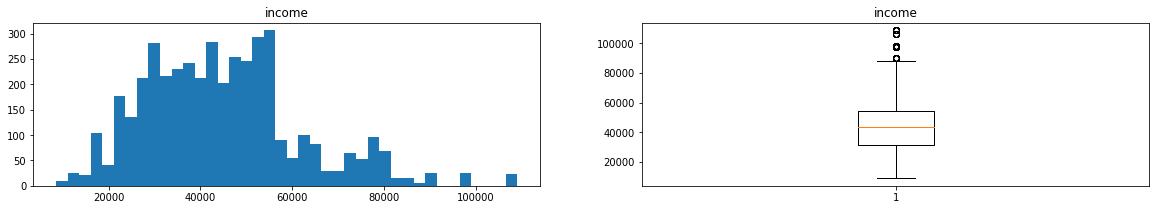

4795 missing vals for tuition
Avg: 21174.93


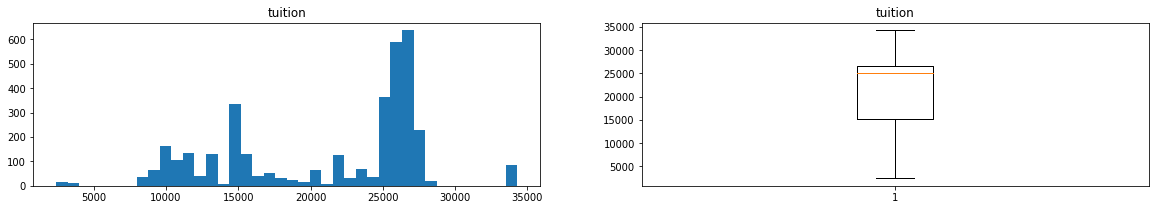

5245 missing vals for mn_sat
Avg: 1299.66


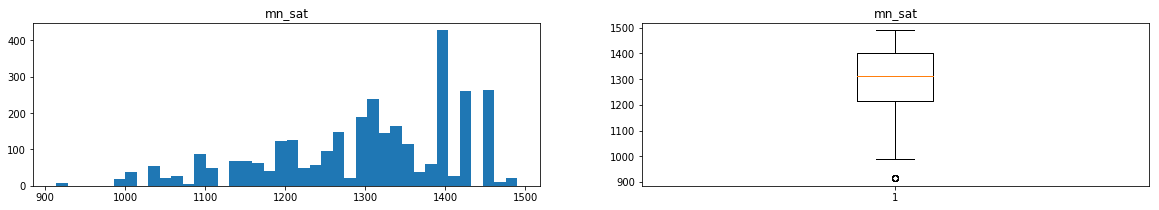

158 missing vals for int_corr
Avg: 0.2


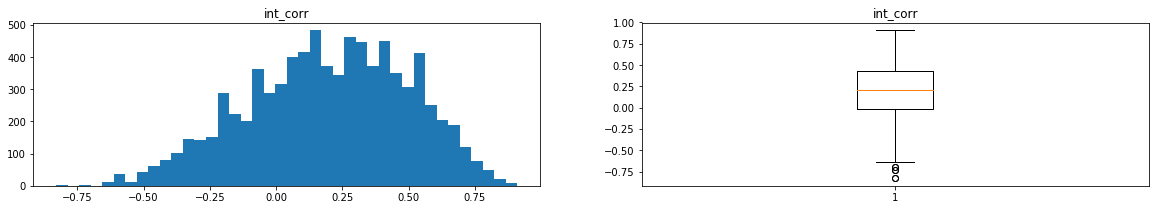

104 missing vals for age_o
Avg: 26.36


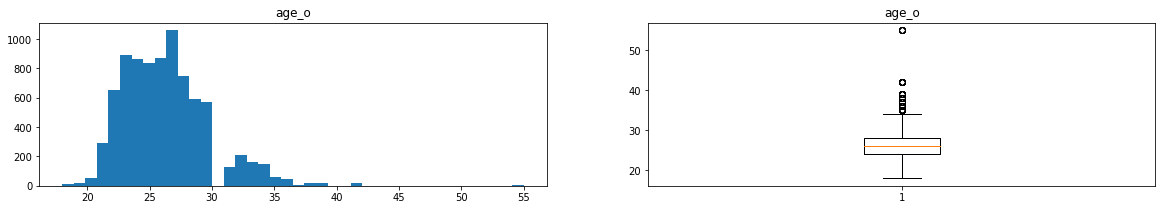

1076 missing vals for shar_o
Avg: 0.15


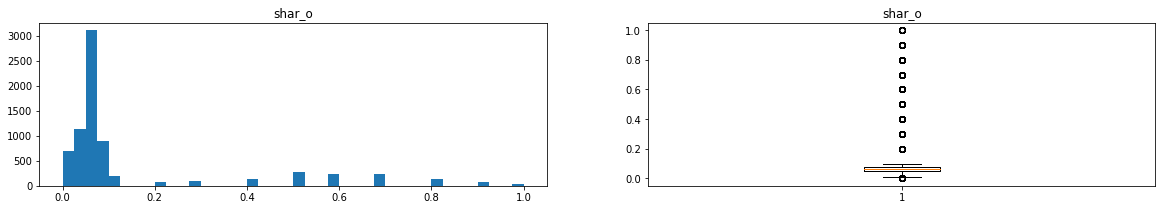

1067 missing vals for shar
Avg: 0.15


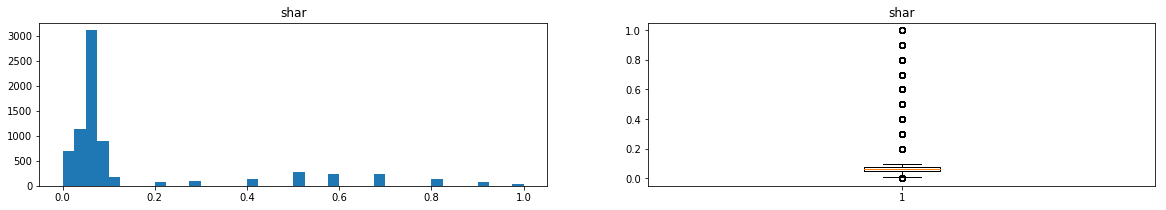

In [4]:
# IMPUTATIONS – income, tuition, mn_sat
def visualize_to_impute(df, cols):
    for col in cols:
        print(df[col].isnull().sum(), 'missing vals for', col)
        df[col] = df[col].apply(lambda x: float(str(x).replace(',','')) if x is not None else 0)

        mean_val = df[col].mean()
        print('Avg:', round(mean_val, 2))

        plt.figure(figsize=(20,3))

        plt.subplot(1, 2, 1)
        plt.hist(df[col].dropna(), bins=40)
        plt.title(col)

        plt.subplot(1, 2, 2)
        plt.boxplot(df[col].dropna())
        plt.title(col)

        plt.show()

        df[col] = df[col].apply(lambda x: x if x > 0 else mean_val)
    return df

raw_data = visualize_to_impute(raw_data, ['income', 'tuition', 'mn_sat', 'int_corr', 'age_o', 'shar_o', 'shar'])

In [5]:
# cols_to_create = ['age_diff_norm', 'same_field_cd', 'same_goal', 'same_income', 'same_tuition']
# cols_to_clean_impute = ['undergra', 'from', 'mn_sat', 'zipcode']

# Clean zip code
raw_data['zipcode'] = raw_data['zipcode'].apply(lambda x: float(str(x).replace(',','')) if x is not None else None)
raw_data = raw_data[raw_data['zipcode'] <= 99950]
raw_data = raw_data[raw_data['zipcode'] >= 501]
raw_data['zipcode'] = raw_data['zipcode'].apply(lambda x: str(x).zfill(5))

In [6]:
# # Drop rows with incorrect math
# df['my_prefs_total'] = df[my_prefs].sum(axis='columns')
# df['partners_prefs_total'] = df[partners_prefs].sum(axis='columns')
# df['guess_opp_sex_prefs_total'] = df[guess_opp_sex_prefs].sum(axis='columns')

# total_col_names = ['my_prefs_total', 'partners_prefs_total', 'guess_opp_sex_prefs_total']
# for col in total_col_names:
#     print(col, '\n* uniq vals –', ', '.join(map(lambda x: str(round(x, 2)), list(df[col].unique()))))

#     # Drop row if math is off by more than 10% (0.1)
#     old_num = df.shape[0]
#     df = df[df[col] <= 1.1]
#     df = df[df[col] >= 0.9]
#     num_dropped = old_num - df.shape[0]
#     perc_dropped = round(num_dropped / old_num * 100, 2)
#     print('* {} rows dropped ({}%) \n* {} rows left\n'.format(num_dropped, perc_dropped, df.shape[0]))

# df = df.drop(columns=total_col_names)
# df.head()

## Feature Engineering

In [7]:
def get_region(from_input):
    for east_region in ['working', 'New York', 'New Jersey', 'New York City', 'Queens', 'J.P. Morgan', 'Vestal', 'Vermont', 'Manhattan', 'Staten', 'Bronx', 'Brandeis', 'Bowdoin', 'Brooklyn', 'Baltimore', 'Boston', 'Maryland', 'Pittsburgh', 'Massachusetts', 'Connecticut', 'Virginia', 'Washington, ', 'Pennsylvania', 'N.Y.', 'Philadelphia', 'NYC', 'Long Island']:
        if east_region.lower() in from_input.lower():
            return 'USA - East'
    for east_abbrev in ['DC', 'MA', 'PA', 'NJ', 'NY', 'MD', 'CT']:
        if east_abbrev in from_input:
            return 'USA - East'
        
    for west_region in ['California', 'San Francisco', 'Los Angeles', '94115', 'Seattle', 'Arizona', 'Salt Lake City', 'San Diego', 'Colorado', 'Hawaii', 'Berkeley', 'Washington State', 'Nevada', 'Oregon', 'New Mexico']:
        if west_region.lower() in from_input.lower():
            return 'USA - West'
    for west_abbrev in ['CA', 'NM']:
        if west_abbrev in from_input:
            return 'USA - West'
        
    for south_region in ['Alabama', 'Texas', 'Georgia', 'Miami', 'Atlanta', 'Florida', 'Carolina', 'Houston', 'Louisiana']:
        if south_region.lower() in from_input.lower():
            return 'USA - South'
    for south_abbrev in ['TN', 'GA', 'TX']:
        if south_abbrev in from_input:
            return 'USA - South'
        
    for midw_region in ['Chicago', 'Minnesota', 'Michigan', 'Missouri', 'Ohio', 'Wisconsin', 'Ann Arbor', 'Minneapolis', 'Detroit', 'Cleveland', 'Nebraska', 'Iowa', 'Kansas']:
        if midw_region.lower() in from_input.lower():
            return 'USA - MidWest'
    for midw_abbrev in ['MI', 'MO', 'OH', 'MN']:
        if midw_abbrev in from_input:
            return 'USA - MidWest'
        
    for eur_region in ['Italy', 'France', 'Germany', 'England', 'Belgium', 'Greece', 'Spain', 'Budapest', 'Sweden', 'Switzerland', 'Paris', 'Albania']:
        if eur_region.lower() in from_input.lower():
            return 'Europe'
        
    for asia_region in ['China', 'Taiwan', 'Philippines', 'Israel', 'Japan', 'Indonesia', 'India', 'Singapore', 'Iran', 'Nepal', 'Russia', 'Hong Kong']:
        if asia_region.lower() in from_input.lower():
            return 'Asia'
        
    for samerica_region in ['South America', 'Brazil', 'Argentina', 'Uruguay', 'Venezuela', 'Panama', 'Puerto Rico']:
        if samerica_region.lower() in from_input.lower():
            return 'Central / S. America / S. Pacific'
    
    if from_input.lower() == 'australia':
        return 'Australia'
    
    if from_input.lower() in ['mexico', 'canada']:
        return 'N. America'

    else:
        return from_input

raw_data['from'] = raw_data['from'].apply(get_region)
raw_data['from'].value_counts()

USA - East                           3128
USA - West                           1141
USA - MidWest                         556
USA - South                           516
Europe                                507
Asia                                  473
Central / S. America / S. Pacific      96
N. America                             53
International Student                  21
Midwest USA                            20
Australia                              20
Name: from, dtype: int64

In [8]:
def first_pass_feat_engineer(row):
    row['male_older'] = is_male_older(row)
    row['same_field_cd'] = is_col_same(row, 'field_cd')
    row['same_career_c'] = is_col_same(row, 'career_c')
    row['match_es_perc'] = row['match_es'] / row['round']
    row['age_diff'] = row['age'] - row['age_o']
    row['same_from'] = is_col_same(row, 'from')
    
    return row

def is_male_older(row):
    return 1 if (row['age'] - row['age_o'] > 0) and (row['gender'] == 1) else 0

def is_col_same(row, col):
    partners_rows = raw_data[raw_data['iid'] == row['pid']]
    if len(partners_rows) > 0:
        partners_row = partners_rows.iloc[0,:]
        return 1 if row[col] == partners_row[col] else 0
    else:
        return float('NaN')

raw_data = raw_data.apply(first_pass_feat_engineer, axis=1)
raw_data.head()

,iid,id,gender,idg,condtn,wave,round,position,positin1,order,...,sinc5_3,intel5_3,fun5_3,amb5_3,male_older,same_field_cd,same_career_c,match_es_perc,age_diff,same_from
0,1,1.0,0,1,1,1,10,7,NaN,4,...,NaN,NaN,NaN,NaN,0,NaN,NaN,0.4,-6.0,NaN
1,1,1.0,0,1,1,1,10,7,NaN,3,...,NaN,NaN,NaN,NaN,0,1.0,0.0,0.4,-1.0,0.0
2,1,1.0,0,1,1,1,10,7,NaN,10,...,NaN,NaN,NaN,NaN,0,1.0,0.0,0.4,-1.0,0.0
3,1,1.0,0,1,1,1,10,7,NaN,5,...,NaN,NaN,NaN,NaN,0,1.0,0.0,0.4,-2.0,1.0
4,1,1.0,0,1,1,1,10,7,NaN,7,...,NaN,NaN,NaN,NaN,0,1.0,0.0,0.4,-3.0,0.0


## Prep Data for Modeling

In [9]:
cols_to_dummify = ['gender', 'condtn', 'samerace', 'from']
cols_to_minscale = ['income', 'tuition', 'mn_sat', 'age_diff']

def dummify_cols(df, cols):
    for col in cols:
        num_nulls = df[col].isnull().sum()

        if num_nulls > 0:
            val_counts = df[col].value_counts()
            most_common_val = val_counts.index[0]
            df[col] = df[col].fillna(value=most_common_val)
            
        df = pd.concat([df.drop(columns=[col], axis=1), pd.get_dummies(df[col], prefix=col)], axis=1)
    return df

def minscale_cols(df, cols):
    for col in cols:
        df[col] = (df[col] - df[col].mean()) / df[col].max()
    return df

raw_data = dummify_cols(raw_data, cols_to_dummify)
raw_data = minscale_cols(raw_data, cols_to_minscale)

In [10]:
diff_my_prefs_and_ratings = []
diff_partners_prefs_and_ratings = []

def get_diff_cols(df):
    for idx in range(len(my_prefs)):
        diff_col = 'diff_my_' + ratings_for_partner[idx]
        diff_my_prefs_and_ratings.append(diff_col)
        df[diff_col] = df[my_prefs[idx]] - df[ratings_for_partner[idx]]

    for idx in range(len(partners_prefs)):
        diff_col = 'diff_partners_' + ratings_for_me[idx]
        diff_partners_prefs_and_ratings.append(diff_col)
        df[diff_col] = df[partners_prefs[idx]] - df[ratings_for_me[idx]]
    
    return df

raw_data = get_diff_cols(raw_data)

In [11]:
def get_cols_many_nans(df):
    cols_many_nans = []
    for col in df.columns:
        if df[col].isnull().sum() > 0:
            num_nans = df[col].isnull().sum()
            percent_nans = round(num_nans / df.shape[0] * 100, 2)
            if percent_nans > 30:
                cols_many_nans.append(col)
    return cols_many_nans

cols_many_nans = get_cols_many_nans(raw_data)
id_cleaned_cols = ['id', 'partner', 'pid', 'idg', 'wave', 'position', 'positin1', 'order', 'dec_o', 'field', 'undergra', 'career', 'match_es', 'round', 'age', 'age_o']
throwaway_cols = ['dec', 'dec_o', 'field_cd', 'goal', 'met', 'met_o', 'go_out', 'numdat_2', 'career_c', 'length', 'date', 'race', 'race_o', 'same_from']

# Drop 1) cols with more than 30% NaNs
# 2) cols with ids and 
# 3) cols with already-imputed / cleaned / dummified cols
# 4) throwaway cols
print('Dropped cols with 30%+ NaNs:', cols_many_nans)
raw_data.drop(labels=(cols_many_nans + id_cleaned_cols + throwaway_cols), axis=1, inplace=True)

raw_data.head()

Dropped cols with 30%+ NaNs: ['undergra', 'expnum', 'attr5_1', 'sinc5_1', 'intel5_1', 'fun5_1', 'amb5_1', 'attr1_s', 'sinc1_s', 'intel1_s', 'fun1_s', 'amb1_s', 'shar1_s', 'attr3_s', 'sinc3_s', 'intel3_s', 'fun3_s', 'amb3_s', 'attr7_2', 'sinc7_2', 'intel7_2', 'fun7_2', 'amb7_2', 'shar7_2', 'attr4_2', 'sinc4_2', 'intel4_2', 'fun4_2', 'amb4_2', 'shar4_2', 'attr2_2', 'sinc2_2', 'intel2_2', 'fun2_2', 'amb2_2', 'shar2_2', 'attr5_2', 'sinc5_2', 'intel5_2', 'fun5_2', 'amb5_2', 'you_call', 'them_cal', 'date_3', 'numdat_3', 'num_in_3', 'attr1_3', 'sinc1_3', 'intel1_3', 'fun1_3', 'amb1_3', 'shar1_3', 'attr7_3', 'sinc7_3', 'intel7_3', 'fun7_3', 'amb7_3', 'shar7_3', 'attr4_3', 'sinc4_3', 'intel4_3', 'fun4_3', 'amb4_3', 'shar4_3', 'attr2_3', 'sinc2_3', 'intel2_3', 'fun2_3', 'amb2_3', 'shar2_3', 'attr3_3', 'sinc3_3', 'intel3_3', 'fun3_3', 'amb3_3', 'attr5_3', 'sinc5_3', 'intel5_3', 'fun5_3', 'amb5_3']


,iid,match,int_corr,pf_o_att,pf_o_sin,pf_o_int,pf_o_fun,pf_o_amb,pf_o_sha,attr_o,...,diff_my_intel,diff_my_fun,diff_my_amb,diff_my_shar,diff_partners_attr_o,diff_partners_sinc_o,diff_partners_intel_o,diff_partners_fun_o,diff_partners_amb_o,diff_partners_shar_o
0,1,0,0.14,0.35,0.20,0.20,0.20,0.00,0.05,0.06,...,0.13,0.08,0.09,0.10,0.29,0.12,0.12,0.12,-0.08,-0.01
1,1,0,0.54,0.60,0.00,0.00,0.40,0.00,0.00,0.07,...,0.13,0.07,0.10,0.09,0.53,-0.08,-0.10,0.33,-0.07,-0.05
2,1,1,0.16,0.19,0.18,0.19,0.18,0.14,0.12,0.10,...,0.11,0.07,0.10,0.08,0.09,0.08,0.09,0.08,0.04,0.02
3,1,1,0.61,0.30,0.05,0.15,0.40,0.05,0.05,0.07,...,0.12,0.08,0.09,0.07,0.23,-0.03,0.06,0.32,-0.04,-0.03
4,1,1,0.21,0.30,0.10,0.20,0.10,0.10,0.20,0.08,...,0.13,0.08,0.09,0.09,0.22,0.03,0.11,0.04,0.01,0.13


1595 missing vals for shar4_1
Avg: 0.26


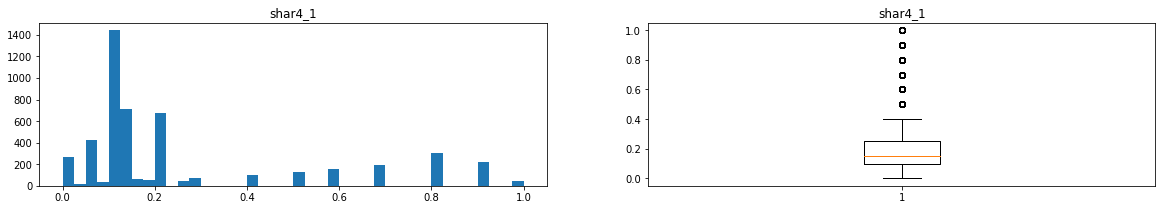

1573 missing vals for attr4_1
Avg: 0.46


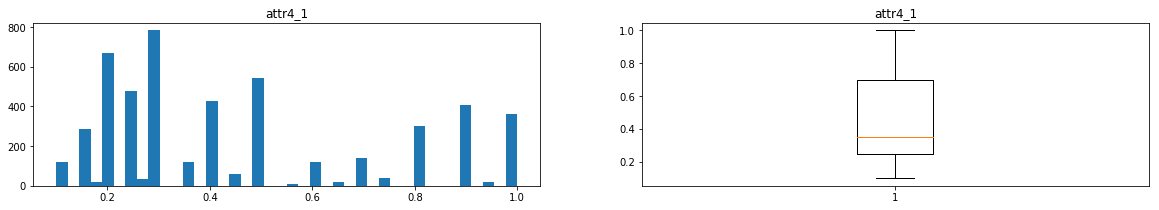

1573 missing vals for sinc4_1
Avg: 0.26


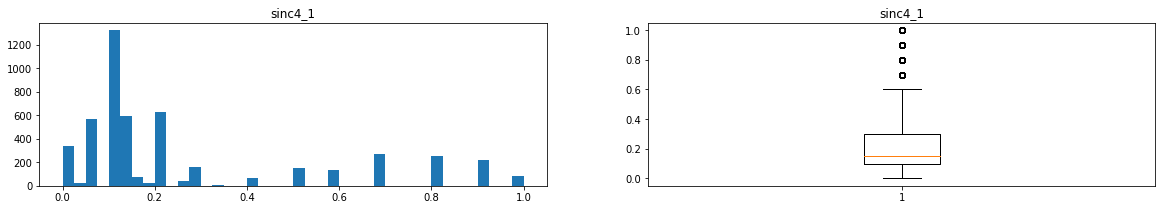

1573 missing vals for intel4_1
Avg: 0.28


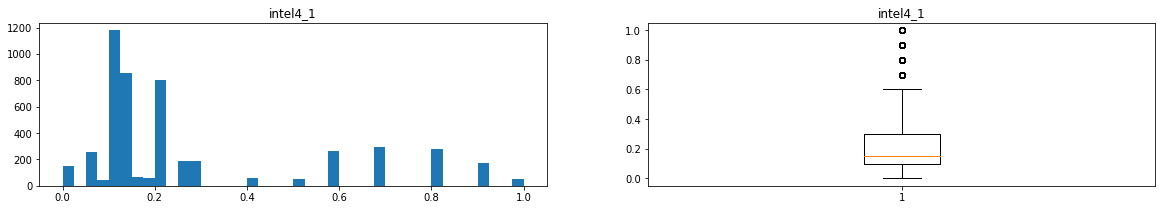

1573 missing vals for fun4_1
Avg: 0.33


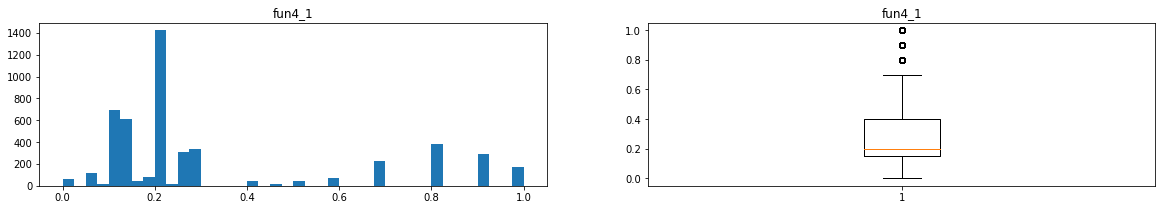

1573 missing vals for amb4_1
Avg: 0.24


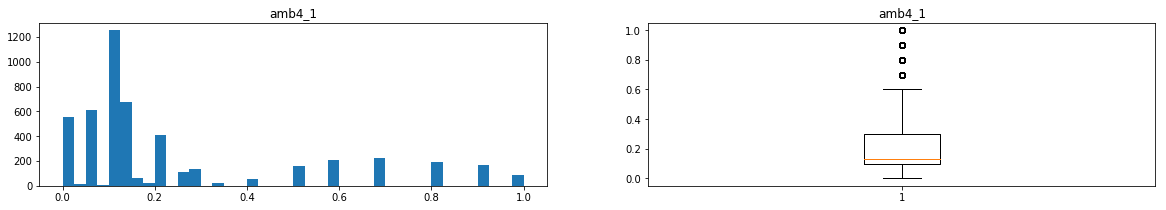

970 missing vals for match_es_perc
Avg: 0.2


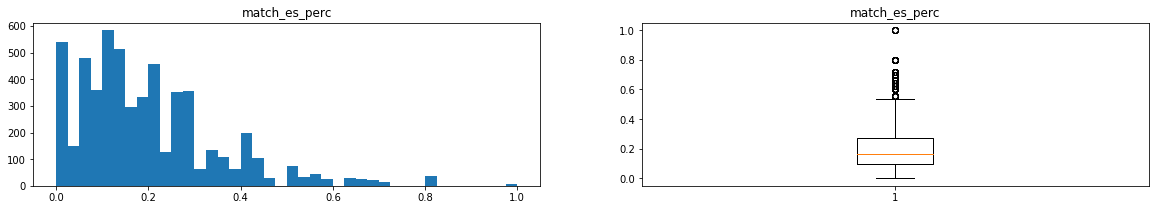

2854 rows(43.7%) dropped
3677 rows (56.3%) left


,iid,match,int_corr,pf_o_att,pf_o_sin,pf_o_int,pf_o_fun,pf_o_amb,pf_o_sha,attr_o,...,diff_my_intel,diff_my_fun,diff_my_amb,diff_my_shar,diff_partners_attr_o,diff_partners_sinc_o,diff_partners_intel_o,diff_partners_fun_o,diff_partners_amb_o,diff_partners_shar_o
1,1,0,0.54,0.60,0.00,0.00,0.4,0.00,0.00,0.07,...,0.13,0.07,0.10,0.09,0.53,-0.08,-0.10,0.33,-0.07,-0.05
3,1,1,0.61,0.30,0.05,0.15,0.4,0.05,0.05,0.07,...,0.12,0.08,0.09,0.07,0.23,-0.03,0.06,0.32,-0.04,-0.03
4,1,1,0.21,0.30,0.10,0.20,0.1,0.10,0.20,0.08,...,0.13,0.08,0.09,0.09,0.22,0.03,0.11,0.04,0.01,0.13
5,1,0,0.25,0.50,0.00,0.30,0.1,0.00,0.10,0.07,...,0.13,0.11,0.09,0.11,0.43,-0.07,0.22,0.02,-0.07,0.03
6,1,0,0.34,0.35,0.15,0.25,0.1,0.05,0.10,0.03,...,0.13,0.11,0.09,0.08,0.32,0.09,0.18,0.05,-0.03,0.03


In [12]:
# Drop rows with null values
def drop_nulls(df):
    old_num = df.shape[0]
    df = df.dropna(axis=0)
    
    num_dropped = old_num - df.shape[0]
    perc_dropped = round(num_dropped / old_num * 100, 2)
    print('{} rows({}%) dropped'.format(num_dropped, perc_dropped))
    
    perc_left = round(df.shape[0] / old_num * 100, 2)
    print('{} rows ({}%) left'.format(df.shape[0], perc_left))
    return df

raw_data = visualize_to_impute(raw_data, ['shar4_1', 'attr4_1', 'sinc4_1', 'intel4_1', 'fun4_1', 'amb4_1', 'match_es_perc'])

# Instead of dropping nulls, could one corroborate with the person's partner's row?
# print(df.isnull().sum().sort_values(ascending=False))

raw_data = drop_nulls(raw_data)
raw_data.head()

In [13]:
df = raw_data.copy()

matches = df[df['match'] == 1]
non_matches = df[df['match'] == 0]

num_matches = matches.shape[0]
num_non_matches = non_matches.shape[0]
perc_minority = round(num_matches / df.shape[0] * 100, 2)
perc_majority = round(num_non_matches / df.shape[0] * 100, 2)

print(('{} TOTAL: \n   {} matches ({}%)\n   {} non-matches ({}%)').format(df.shape[0], num_matches, perc_minority, num_non_matches, perc_majority))

3677 TOTAL: 
   687 matches (18.68%)
   2990 non-matches (81.32%)


## Data Visualization Helper Methods

In [14]:
def show_distributions(df):
    plt.figure(figsize=(20, 3))
    
    matches = df[df['match'] == 1]
    non_matches = df[df['match'] == 0]

    for idx, col in enumerate(cols_of_interest):
        plt.subplot(1, 6, idx + 1)
        plt.hist(matches[col], alpha=0.4, bins= 20, color='green', label='matches')
        plt.hist(non_matches[col], alpha=0.4, bins= 20, color='red', label='non-matches')
        plt.legend()
        plt.title(col)

    plt.show()

def show_boxplots(df):
    plt.figure(figsize=(20, 3))
    
    matches = df[df['match'] == 1]
    non_matches = df[df['match'] == 0]

    for idx, col in enumerate(cols_of_interest):
        plt.subplot(1, 6, idx + 1)
        plt.boxplot([matches[col], non_matches[col]])
        plt.title(col + ' - matches vs. non-matc.')

    plt.show()

In [15]:
# TODO: clean to see if improves score
df.zipcode = pd.to_numeric(df.zipcode)
df.drop(columns=['zipcode'], inplace=True)
df.head()

,iid,match,int_corr,pf_o_att,pf_o_sin,pf_o_int,pf_o_fun,pf_o_amb,pf_o_sha,attr_o,...,diff_my_intel,diff_my_fun,diff_my_amb,diff_my_shar,diff_partners_attr_o,diff_partners_sinc_o,diff_partners_intel_o,diff_partners_fun_o,diff_partners_amb_o,diff_partners_shar_o
1,1,0,0.54,0.60,0.00,0.00,0.4,0.00,0.00,0.07,...,0.13,0.07,0.10,0.09,0.53,-0.08,-0.10,0.33,-0.07,-0.05
3,1,1,0.61,0.30,0.05,0.15,0.4,0.05,0.05,0.07,...,0.12,0.08,0.09,0.07,0.23,-0.03,0.06,0.32,-0.04,-0.03
4,1,1,0.21,0.30,0.10,0.20,0.1,0.10,0.20,0.08,...,0.13,0.08,0.09,0.09,0.22,0.03,0.11,0.04,0.01,0.13
5,1,0,0.25,0.50,0.00,0.30,0.1,0.00,0.10,0.07,...,0.13,0.11,0.09,0.11,0.43,-0.07,0.22,0.02,-0.07,0.03
6,1,0,0.34,0.35,0.15,0.25,0.1,0.05,0.10,0.03,...,0.13,0.11,0.09,0.08,0.32,0.09,0.18,0.05,-0.03,0.03


## Over-Sampling to Counter Skewed Data

Because my dataset is so skewed in favor of non-matches, I will be over-sampling from my smaller group (matches) in order to train my models accurately.

In [16]:
# cols_of_interest = df.columns[df.columns != 'match']
# cols_of_interest = ['iid', 'pf_o_amb', 'pf_o_sha', 'attr_o', 'intel_o', 'fun_o', 'shar_o',
#        'like_o', 'prob_o', 'attr', 'intel', 'fun', 'shar', 'like', 'prob',
#        'sinc1_2', 'match_es_perc', 'diff_my_fun', 'diff_my_amb',
#        'diff_my_shar', 'diff_partners_intel_o', 'diff_partners_fun_o']
cols_of_interest = ['iid', 'attr_o', 'fun_o', 'like_o', 'prob_o', 'attr', 'like']

High scorers: [14, 49, 86, 91, 92, 99, 105, 107, 109, 112, 125, 142, 208, 212, 215, 217, 268, 269, 316, 354, 366, 369, 387, 448, 467, 469, 470, 489, 492, 509, 516, 524, 535, 546]


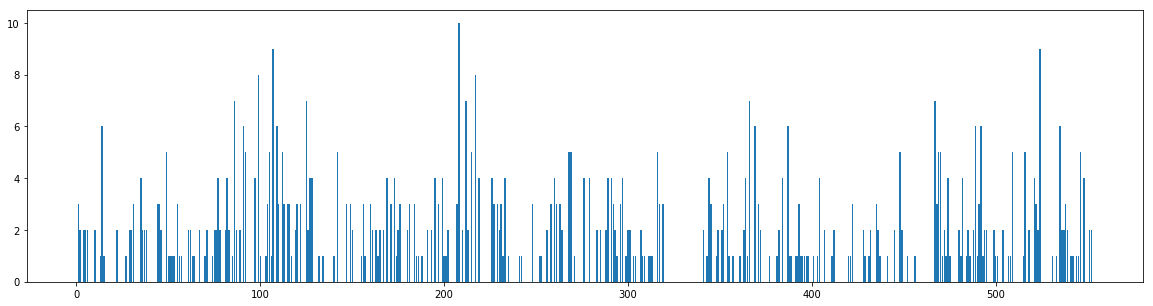

In [17]:
# Cheating to use iid?
match_totals = df.groupby('iid').sum()['match']
all_iids = list(match_totals.index)
over_4_matches = list(map(lambda x: x >= 5, match_totals))
print('High scorers:', list(compress(all_iids, over_4_matches)))

plt.figure(figsize=(20,5))
plt.bar(all_iids, height=match_totals)
plt.show()

In [18]:
df.drop(columns='iid', inplace=True)
cols_of_interest = list(filter(lambda col: col != 'iid', cols_of_interest))

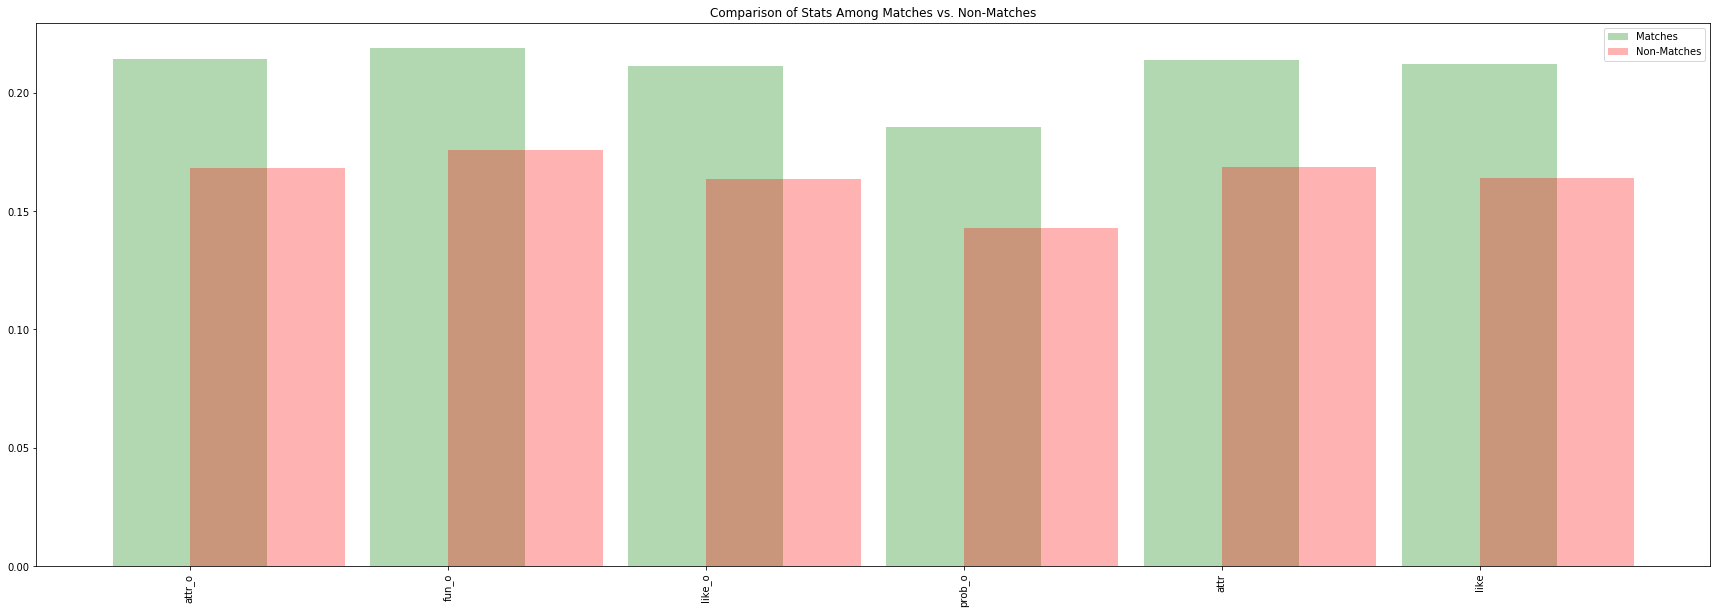

In [19]:
matches = df[df['match'] == 1]
non_matches = df[df['match'] == 0]

plt.figure(figsize=(30,10))

plt.bar(cols_of_interest, height=matches[cols_of_interest].mean(), width=0.6, color='green', alpha=0.3, label='Matches')
plt.bar(cols_of_interest, height=non_matches[cols_of_interest].mean(), width=0.6, color='red', align='edge', alpha=0.3, label='Non-Matches')
plt.title('Comparison of Stats Among Matches vs. Non-Matches')
plt.xticks(rotation=90)
plt.legend()

plt.show()

In [20]:
train_df = df.loc[::2, cols_of_interest + ['match']]
test_df = df.loc[1::2, cols_of_interest + ['match']]

In [21]:
X = df.loc[:, cols_of_interest]
Y = df['match']

X_train = train_df.loc[:, cols_of_interest]
Y_train = train_df['match']

X_test = test_df.loc[:, cols_of_interest]
Y_test = test_df['match']

sm = SMOTE(random_state=1, ratio = 1.0)
X_train_res, Y_train_res = sm.fit_sample(X_train, Y_train)

Counter(Y_train_res)

/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function _ratio_float is deprecated; Use a float for 'ratio' is deprecated from version 0.2. The support will be removed in 0.4. Use a dict, str, or a callable instead.
  warnings.warn(msg, category=DeprecationWarning)


Counter({0: 1489, 1: 1489})

In [22]:
oversampled_X_train, oversampled_X_test, oversampled_Y_train, oversampled_Y_test = train_test_split(X_train_res, Y_train_res, test_size=0.25, random_state=1)

In [23]:
df = pd.DataFrame(data = oversampled_X_train, columns=cols_of_interest)
df['match'] = oversampled_Y_train

df.head()

,attr_o,fun_o,like_o,prob_o,attr,like,match
0,0.04,0.04,0.05,0.07,0.08,0.03,0
1,0.03,0.09,0.04,0.02,0.08,0.07,0
2,0.30,0.60,0.80,0.80,0.50,0.80,0
3,0.60,0.70,0.60,0.60,0.60,0.60,0
4,0.08,0.08,0.08,0.07,0.06,0.06,0


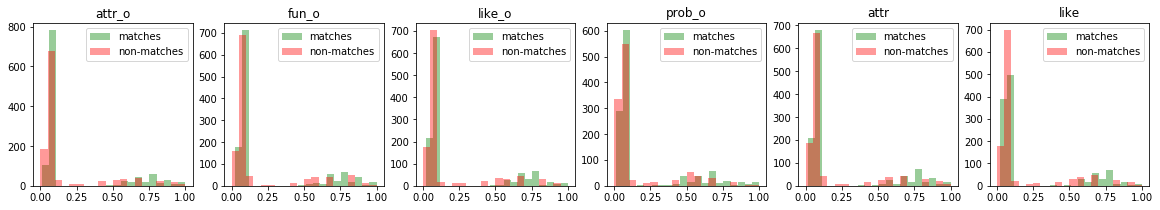

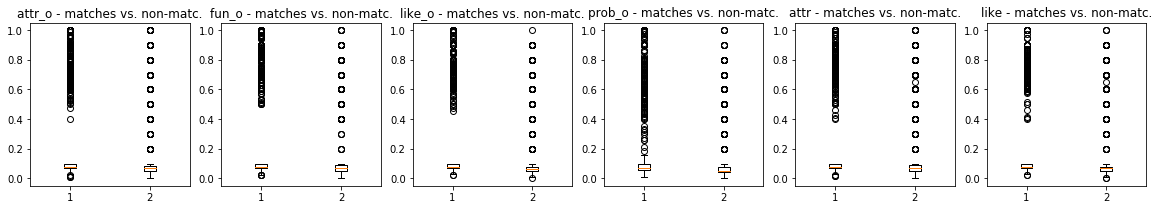

In [24]:
show_distributions(df)
show_boxplots(df)

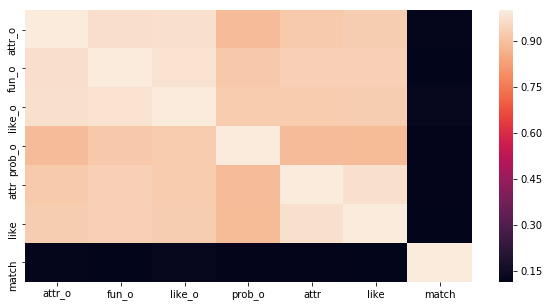

In [25]:
plt.figure(figsize=(10,5))
sns.heatmap(df.corr())
plt.show()

# Model for Target

Try several different approaches and work to tune a variety of models before using the model evaluation techniques to choose what you consider to be the best performer. 

Think about explanatory versus predictive power and experiment with both.

In [30]:
def get_errors(crosstab):
    tI_errors = crosstab.loc[0,1] / crosstab.loc['All','All'] * 100
    tII_errors = crosstab.loc[1,0] / crosstab.loc['All','All'] * 100
    print(('\nType I errors: {}%\nType II errors: {}%\n').format(round(tI_errors, 2), round(tII_errors, 2)))
    
def get_precision_recall(crosstab):
    precision = crosstab.loc[1,1] / crosstab.loc['All', 1] * 100 
    recall = crosstab.loc[1,1] / crosstab.loc[1,'All'] * 100 
    print(('Precision: {}%\nRecall: {}%').format(round(precision, 2), round(recall, 2)))

def fit_and_train(model):
    model_fit = model.fit(oversampled_X_train, oversampled_Y_train)
    model_score_train = model.score(oversampled_X_test, oversampled_Y_test)
    print('***TRAIN***')
    print('R² for train:', model_score_train)
    
    train_crosstab = pd.crosstab(oversampled_Y_train, model_fit.predict(oversampled_X_train), rownames=['actual'], colnames=['predicted'], margins=True)
    print(train_crosstab)
    
    get_errors(train_crosstab)
    get_precision_recall(train_crosstab)
    
    model_score_test = model.score(X_test, Y_test)
    print('\n***TEST***')
    print('R² for test:', model_score_test)
    
    test_crosstab = pd.crosstab(Y_test, model_fit.predict(X_test), rownames=['actual'], colnames=['predicted'], margins=True)
    print(test_crosstab)
    
    get_errors(test_crosstab)
    get_precision_recall(test_crosstab)
    
    model_score_whole = model.score(X, Y)
    print('\n***WHOLE***')
    print('R² for whole:', model_score_whole)
    
    whole_crosstab = pd.crosstab(Y, model_fit.predict(X), rownames=['actual'], colnames=['predicted'], margins=True)
    print(whole_crosstab)
    
    get_errors(whole_crosstab)
    get_precision_recall(whole_crosstab)
    
    if hasattr(model_fit, 'coef_'):
        print('\nCoefficients:', model_fit.coef_)

lasso = linear_model.LogisticRegression(penalty='l1', C=10) 
fit_and_train(lasso)

***TRAIN***
R² for train: 0.5409395973154363
predicted     0    1   All
actual                    
0           912  183  1095
1           853  285  1138
All        1765  468  2233

Type I errors: 8.2%
Type II errors: 38.2%

Precision: 60.9%
Recall: 25.04%

***TEST***
R² for test: 0.7156063077759652
predicted     0    1   All
actual                    
0          1223  266  1489
1           257   93   350
All        1480  359  1839

Type I errors: 14.46%
Type II errors: 13.97%

Precision: 25.91%
Recall: 26.57%

***WHOLE***
R² for whole: 0.7079140603753059
predicted     0    1   All
actual                    
0          2441  549  2990
1           525  162   687
All        2966  711  3677

Type I errors: 14.93%
Type II errors: 14.28%

Precision: 22.78%
Recall: 23.58%

Coefficients: [[ 0.36334928 -2.8653239   3.12389238  0.23400339  0.6503148  -0.31507101]]


***TRAIN***
R² for train: 0.8832214765100671
predicted     0     1   All
actual                     
0          1091     4  1095
1             3  1135  1138
All        1094  1139  2233

Type I errors: 0.18%
Type II errors: 0.13%

Precision: 99.65%
Recall: 99.74%

***TEST***
R² for test: 0.9526916802610114
predicted     0    1   All
actual                    
0          1441   48  1489
1            39  311   350
All        1480  359  1839

Type I errors: 2.61%
Type II errors: 2.12%

Precision: 86.63%
Recall: 88.86%

***WHOLE***
R² for whole: 0.8830568398150667
predicted     0    1   All
actual                    
0          2778  212  2990
1           218  469   687
All        2996  681  3677

Type I errors: 5.77%
Type II errors: 5.93%

Precision: 68.87%
Recall: 68.27%


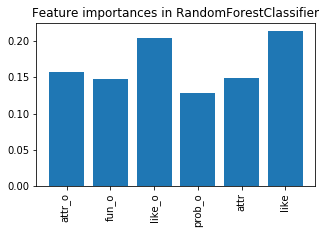

***IMPORTANT COLS:*** ['attr_o', 'fun_o', 'like_o', 'prob_o', 'attr', 'like']


In [38]:
rfc = ensemble.RandomForestClassifier(n_estimators=5000, random_state=10)
fit_and_train(rfc)

plt.figure(figsize=(5,3))
important_cols = (rfc.feature_importances_ > 0.05)
plt.bar(X_train.columns[important_cols], height=rfc.feature_importances_[important_cols])
plt.xticks(rotation=90)
plt.title('Feature importances in RandomForestClassifier')
plt.show()

print('***IMPORTANT COLS:***', list(X_train.columns[important_cols]))

In [32]:
gbm = ensemble.GradientBoostingClassifier(n_estimators=500, max_depth=2, loss='deviance')
fit_and_train(gbm)

***TRAIN***
R² for train: 0.876510067114094
predicted     0     1   All
actual                     
0          1019    76  1095
1            91  1047  1138
All        1110  1123  2233

Type I errors: 3.4%
Type II errors: 4.08%

Precision: 93.23%
Recall: 92.0%

***TEST***
R² for test: 0.8656878738444806
predicted     0    1   All
actual                    
0          1364  125  1489
1           122  228   350
All        1486  353  1839

Type I errors: 6.8%
Type II errors: 6.63%

Precision: 64.59%
Recall: 65.14%

***WHOLE***
R² for whole: 0.8373674190916508
predicted     0    1   All
actual                    
0          2687  303  2990
1           295  392   687
All        2982  695  3677

Type I errors: 8.24%
Type II errors: 8.02%

Precision: 56.4%
Recall: 57.06%


## Conclusion

My Random Forest Classifier model performed the best – it had an R-squared value of ~88% on the whole dataset, as well as a precision and recall rate of ~68%. Both Type I and Type II errors were below 6%. 

The only downside is that the model may be slightly overfitted, as it has a train R² of ~88% and a test R² of ~95%. I could adjust the model's hyperparameters to bring these 2 R² values closer together, but it would negatively impact the precision and recall rates. Depending on what I want to optimize for, I can easily tweak the hyperparameters to raise the value for different scores.

## Deliverables

Prepare a slide deck and 15 minute presentation that guides viewers through your model. Be sure to cover a few specific things:

- A specified research question your model addresses
- How you chose your model specification and what alternatives you compared it to
- The practical uses of your model for an audience of interest
- Any weak points or shortcomings of your model

You'll be presenting this slide deck live to a group as the culmination of your work in the last 2 supervised learning units. As a secondary matter, your slides and/or the Jupyter notebook you use or adapt them into should be worthy of inclusion as examples of your work product when applying to jobs.

In [29]:
# notes
# parametric vs non-parametric models 
# lasso is parametric – there are conventions; features should be norm.distributed; no multicollinearity
# lasso – will help with multicollinearity

#    Over Sampling: 
# Create two parts of whole datasets (original dataset having both frauds and no frauds) - train and  test
#  Oversample the fraud part of train dataset to make it 50% each fraud and non fraud. Split this dataset in train and test - call them Over_Sampled_train, Over_Sampled_test
#  train your tree based model on Over_Sampled_train and test it on Over_Sampled_test. record precision and recall.
#  Not test the above trained model on test dataset create at the start of over sampling. Record recision and recall.